## 1: Introduction

CS4287 Option 2 -  Atari with extra credit 6% - implement DQN for one of the environments in OpenAI Gym for an Atari game.

Names: Christopher Brophy (22356053), Mark Hughes (22339132)
Game: Atari Breakout

## 2: Why Reinforcement Learning is the machine learning paradigm of choice for this task

Reinforcement Learning is the correct paradigm for this task because:<br>
1) Sequential Desicion Making: 
    - Breakout is a game where the agent must make a series of decisions over time. Each action influences the next state of the game.
    - Reinforcement Learning (RL) handles such sequential decision-making problems because it learns policies that maximise long-term rewards, not just immediate outcomes.
2) Delayed Rewards:
    - Big amounts of points are only earned when the ball breaks a brick, which happens several steps after the agent moves the paddle.
    - RL is designed to learn from delayed rewards, unlike supervised learning.
3) Interaction with Environment:
    - RL allows the agent to learn from trial and error by interacting with the environment. 
    - This agent sees the consequences of its actions and adjusts its strategy to improve performance over time.
    - Supervised learning would need datasets of ideal, optimal moves, which don't exist.
4) No explicit supervision:
    - There is no "correct" move dataset for every state in breakout.
    - RL allows the agent to learn automatically by exploring actions and maximising rewards.

In [10]:
%pip install "gymnasium[atari]" ale-py autorom

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\csbro\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## 3: The Gym Environment

OpenAI Gym provides a standardised interface for reinforcement learning environments.<br>

For Atari Breakout:
1) Environment Creation
    - It initialises the game for me further down with the function "gym.make('ALE/Breakout-v5')".
    - Handles game mechanics, rendering, and scoring automatically.
2) Interactions
    - "obs, reward, terminated, truncated, info = env.step(action)" lets the agent take actions.
        - obs = the next game frame
        - reward = points received for the action
        - terminated = whether the game is over
        - truncated = whether the episode ended due to time
        - info = additional info such as lives
3) Why it's useful
    - Provides a ready-made environment for testing RL agents.
    - Base rewards such as breaking bricks is automatic.

In [11]:
import gymnasium as gym
import ale_py
import numpy as np
import random
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, clear_output

gym.register_envs(ale_py)

## 4(a): Capture and pre-processing of the data

1) Capture: The agent gets raw RGB frames from Gym.
2) Preprocessing: 
    - Frames are converted to grayscale to reduce complexity.
    - Resized to 84x84 to standardise input dimensions.
    - It is then converted to a numpy array for pytorch to use.
3) Reward Shaping:
    - In addition to preprocessing, the reward is modified based on structured game features toencourage desirable behaviour.
    - Reward shaping provides richer, more consistent feedback, helping the agent converge faster.

In [12]:
def preprocess_frame(frame):
    img = Image.fromarray(frame).convert('L')
    img = img.resize((84, 84), Image.NEAREST)
    return np.array(img, dtype=np.float32) / 255.0

def show_frame_inline(frame_rgb, paddle_x=None, reward=None, action=None, q_values=None, scale=5, font_size=22):
    # copy frame and resize it
    arr = frame_rgb
    if arr.dtype == np.float32 or arr.dtype == np.float64:
        arr = (np.clip(arr, 0, 1) * 255).astype(np.uint8)
    img = Image.fromarray(arr)
    img = img.resize((img.width*scale, img.height*scale), Image.NEAREST)

    # create context for drawing and font
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()

    y = 1
    spacing = font_size

    # draw current reward to gui
    if reward is not None:
        draw.text((5, y), f"Reward: {reward:.2f}", fill=(0,255,0), font=font)
        y += spacing
    
    # draw current paddle x to gui
    if paddle_x is not None:
        draw.text((5, y), f"Paddle X: {paddle_x}", fill=(0,255,0), font=font)
        y += spacing

    # draw current action to gui
    if action is not None:
        draw.text((5, y), f"Action: {action}", fill=(0,255,0), font=font)
        y += spacing

    # draw q values to gui
    if q_values is not None:
        q_str = ", ".join([f"{v:.2f}" for v in q_values])
        draw.text((5, y), f"Top Q: {q_str}", fill=(0,255,0), font=font)

    clear_output(wait=True)
    display(img)

## 4(b): Network Structure

1) Input:
    - The network takes stacked frames as input with shape (channel, height, width)
    - For Breakout, typically 4 frames are stacked to capture motion.
2) Convolutional Layers:
    - Three convolutional layers exxtract spacial features from the input frames:
        1) Conv2d(32, kernel=8, stride=4) => Extracts large spatial patterns (ball, paddle)
        2) Conv2d(64, kernel=4, stride=2) => Finer spatial features
        3) Conv2d(64, kernel=3, stride=1) => Detailed local features
    - ReLU activations after each layer introduce non-linearality.
    - These layers convert raw pixel input into a feature representation sutiable for Q-value learning.
3) Fully connected layers:
    - Flattens the convolutional input into a single vector.
    - This flattened vector is passed through:
        1) nn.Linear(conv_out_size, 512) followed by ReLU
        2) nn.Linear(512, n_actions)
    - The final layer outputs one Q-value per possible action in the environment.
    

In [13]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        c, h, w = input_shape # channels, height, width
        
        # Convolutional feature extractor
        # ReLU after each layer ensures nonlinearity.
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # compute conv out size
        with torch.no_grad():
            dummy = torch.zeros(1, c, h, w)
            conv_out_size = int(np.prod(self.conv(dummy).shape[1:]))
        
        # fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        x = self.conv(x)            # pass input through convolutional feature extractor
        x = x.view(x.size(0), -1)   # flatten spacial values into single vector
        return self.fc(x)           # pass flattened values through fully connected layers

## Replay Buffer

This is used to store experiences for the DQN to train on later on.<br>
Storing the samples and sampling randomly them for training then:
- Breaks correlation between consecutive samples
- Stabilizes training
- Allows re-using experiences multiple times (improves sample efficiency)

In [14]:
class ReplayBuffer:
    def __init__(self, capacity, state_shape):
        self.capacity = capacity
        self.state_shape = state_shape

        # initialise empties
        self.ptr = 0
        self.size = 0
        self.states = np.zeros((capacity, *state_shape), dtype=np.float32)
        self.next_states = np.zeros((capacity, *state_shape), dtype=np.float32)
        self.actions = np.zeros((capacity,), dtype=np.int64)
        self.rewards = np.zeros((capacity,), dtype=np.float32)
        self.dones = np.zeros((capacity,), dtype=np.float32)

    def push(self, state, action, reward, next_state, done):
        self.states[self.ptr] = state
        self.next_states[self.ptr] = next_state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.dones[self.ptr] = float(done)
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        # get random batch from buffer
        idx = np.random.choice(self.size, batch_size, replace=False)
        return {
            "states": self.states[idx],
            "actions": self.actions[idx],
            "rewards": self.rewards[idx],
            "next_states": self.next_states[idx],
            "dones": self.dones[idx]
        }

    def __len__(self):
        return self.size

## 4(c): Where the Q-Learning update is applied to the weights

The train_step() function applies the Deep Q-Learning update by changing the weights of q_net, which is the main Q-network being trained. Its predictions are compared to target values that come from the separate target network.

1) q_net is the network that actually learns. It produces the Q-values for the actions taken, and its weights are adjusted during training.
2) target_net provides stable target values. It is a copy of q_net that is not updated during each training step, so it gives consistent targets.
3) Only q_net is updated during the learning step. When backpropagation and the optimizer run, they modify the parameters of q_net only, while target_net remains unchanged until it is periodically refreshed.

In [15]:
def train_step(q_net, target_net, optimizer, batch, gamma=0.99, device="cpu"):
    # convert all batch lists to tensors
    states = torch.tensor(batch['states'], dtype=torch.float32, device=device)
    actions = torch.tensor(batch['actions'], dtype=torch.long, device=device)
    rewards = torch.tensor(batch['rewards'], dtype=torch.float32, device=device)
    next_states = torch.tensor(batch['next_states'], dtype=torch.float32, device=device)
    dones = torch.tensor(batch['dones'], dtype=torch.float32, device=device)

    # compute q-values for current states
    q_vals = q_net(states)
    q_s_a = q_vals.gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q = target_net(next_states)                    # look at the next states
        next_q_max = next_q.max(1)[0]                       # find the best next action
        target = rewards + gamma * next_q_max * (1 - dones) # build the target value
    
    # Huber loss between predicted Q(s,a) and target value
    loss = F.smooth_l1_loss(q_s_a, target)

    # Standard optimizer step
    optimizer.zero_grad()
    loss.backward()

    # Gradient clipping to avoid exploding updates
    torch.nn.utils.clip_grad_norm_(q_net.parameters(), 10.0)

    optimizer.step()
    return loss.item()

## Initialisation and Hyperparameters

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Environment
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array", repeat_action_probability=0.3) # keep actions for anti-jitter
obs, info = env.reset(seed=42)

# initial lives
lives = info.get('lives', 5)

# state stack init
frame0 = preprocess_frame(obs)
state_stack = np.stack([frame0]*4, axis=0)  # shape (4,84,84)
state = state_stack.copy()

# networks
n_actions = env.action_space.n
q_net = DQN(input_shape=(4,84,84), n_actions=n_actions).to(device)
q_net.train()

target_net = DQN(input_shape=(4,84,84), n_actions=n_actions).to(device)
target_net.load_state_dict(q_net.state_dict())
target_net.eval()

# optimizer
optimizer = optim.Adam(q_net.parameters(), lr=1e-4)

# replay buffer
replay_capacity = 10000
buffer = ReplayBuffer(replay_capacity, state_shape=(4,84,84))

# hyperparams
batch_size = 32                 # size of batches of frames
gamma = 0.80                    # how much the aget cares about future rewards
initial_eps = 1.0               # initial epsilon before decay
final_eps = 0.05                # final epsilon after decay
eps_decay_steps = 1_000_00      # linear decay over this many steps
start_train = 10000             # number of transitions before training starts
train_freq = 4                  # train every n env steps
target_update_freq = 10000      # sync target net every n env steps
max_env_steps = 1_000_000       # total env steps to run
save_path = "dqn_breakout.pth"  # path for saved model

# rewards & punishments
alignment_strength = 0.3
anti_edge_strength = 0.1
life_lost_penalty = 2.0
anti_jitter_num = 0.02

# bookkeeping
total_steps = 0
episode = 0
loss_history = []
prev_paddle_center = None
prev_action = None

Using device: cpu


## Data Logger

In [17]:
LOG_STEP_INTERVAL = 1000

# open csv file
episode_f = open("stats/episodes.csv", "w+", newline="")
episode_writer = csv.writer(episode_f)
episode_writer.writerow(["episode", "env_return", "shaped_return", "length", "lives_lost"])

reward_f = open("stats/reward_components.csv", "w+", newline="")
reward_writer = csv.writer(reward_f)
reward_writer.writerow(["step", "base_reward", "life_penalty", "alignment_reward", "edge_penalty", "jitter_reward", "total_reward"])

train_f = open("stats/training.csv", "w+", newline="")
train_writer = csv.writer(train_f)
train_writer.writerow(["step", "loss", "q_mean", "q_max"])

# accumulators
step_acc = {
    "base_reward": 0.0,
    "life_penalty": 0.0,
    "alignment_reward": 0.0,
    "edge_penalty": 0.0,
    "jitter_reward": 0.0,
    "total_reward": 0.0,
    "count": 0
}

# episode stats
ep_env_return = 0.0
ep_shaped_return = 0.0
ep_len = 0
ep_lives_lost = 0

## Reward Shaping
1) Base Reward:
    - The agent receives the environment's default reward from Gym, which includes points for breaking a block.
2) Modification based on game features:
    - Multiply base reward: Rewards from breaking bricks are scaled (3x) to emphasie their importance.
    - Life loss penalty: If the agent loses lives, a pentaly is given to discourage risky actions.
    - Alignment Reward: The closer the paddle is to the ball's x-position, the higher the reward.
    - Anti edge-hugging penalty: The agent is discouraged from staying near the edges of the screen.
    - Anti-jitter smoothing: Small rewards and penalties to keep action consistency to reduce paddle jitter.
3) Purpose:
    - These modifications move the agent towards desirable behaviours beyond just breaking bricks.
    - They speed up learning by providing more freqeunt and informative feedback.

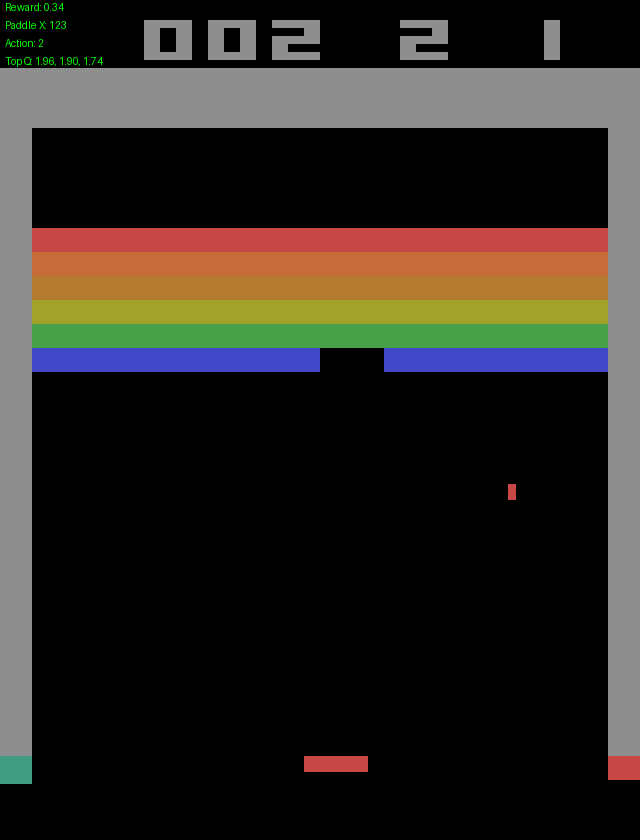

In [ ]:
display_interval = 3
last_display = 0

PADDLE_WIDTH = 16
PADDLE_Y = 193  
SCREEN_CENTER = 128

while total_steps < max_env_steps:
    # epsilon linear decay
    eps = max(final_eps, initial_eps - (initial_eps - final_eps) * (total_steps / eps_decay_steps))

    # choose action
    if random.random() < eps:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            st = torch.tensor(state.astype(np.float32), dtype=torch.float32, device=device).unsqueeze(0)
            qvals = q_net(st).cpu().numpy()[0]
            action = int(np.argmax(qvals))

    # step env
    obs, reward, terminated, truncated, info = env.step(action)
    total_steps += 1

    # data for logging
    raw_reward = reward
    ep_env_return += raw_reward

    # multiply base block reward
    reward *= 3

    # detect life loss and apply penalty
    life_penalty = 0.0
    new_lives = info.get('lives', lives)
    life_lost = new_lives < lives
    lives = new_lives
    if life_lost:
        life_penalty = -life_lost_penalty
        reward += life_penalty
        ep_lives_lost += 1

    # access ram values
    ram = env.unwrapped.ale.getRAM()
    ball_x = ram[99]
    ball_y = ram[101]
    paddle_x = ram[72]
    paddle_center = paddle_x + 16/2
    max_dist = SCREEN_CENTER
    
    # Alignemnt reward
    alignment_error = abs(paddle_center - ball_x)
    alignment_reward = (255 - alignment_error) / 255.0
    reward += alignment_reward * alignment_strength

    # anti edge-hugging
    dist_from_center = abs(paddle_center - SCREEN_CENTER)
    if abs(ball_y - PADDLE_Y) > 20:   # adjust threshold depending on RAM scale
        dist_from_center = abs(paddle_center - SCREEN_CENTER)
        edge_penalty = dist_from_center / max_dist
        reward -= edge_penalty * anti_edge_strength

    # anti jitter
    jitter_reward = 0.0
    if prev_action is not None:
        jitter_reward = anti_jitter_num if action == prev_action else -anti_jitter_num
        reward += jitter_reward
    prev_action = action

    # keep track of shaped reward
    ep_shaped_return += reward
    ep_len += 1

    # rewards for step
    step_acc["base_reward"] += raw_reward
    step_acc["life_penalty"] += life_penalty
    step_acc["alignment_reward"] += alignment_reward
    step_acc["edge_penalty"] += edge_penalty
    step_acc["jitter_reward"] += jitter_reward
    step_acc["total_reward"] += reward
    step_acc["count"] += 1

    # preprocess next state
    next_frame = preprocess_frame(obs)
    next_state = np.roll(state, shift=-1, axis=0)
    next_state[-1] = next_frame

    # training 'done' flag
    done_for_training = bool(terminated or truncated)

    # push to replay buffer
    buffer.push(state.copy(), action, reward, next_state.copy(), done_for_training)

    # advance current state
    state = next_state

    # If the actual episode ended then reset environment and bookkeeping
    if terminated or truncated:
        # log episode stats
        episode_writer.writerow([
            episode,
            ep_env_return,
            ep_shaped_return,
            ep_len,
            ep_lives_lost
        ])
        episode_f.flush()

        # reset episode accumulators
        ep_env_return = 0.0
        ep_shaped_return = 0.0
        ep_len = 0
        ep_lives_lost = 0

        # reset env
        obs, info = env.reset()
        lives = info.get('lives', 5)
        frame0 = preprocess_frame(obs)
        state = np.stack([frame0]*4, axis=0)
        episode += 1

    # Training step
    if len(buffer) >= start_train and (total_steps % train_freq == 0):
        batch = buffer.sample(batch_size)
        loss = train_step(q_net, target_net, optimizer, batch, gamma=gamma, device=device)
        loss_history.append(loss)

        # get batch states and log
        with torch.no_grad():
            states_t = torch.tensor(
                batch["states"],
                dtype=torch.float32,
                device=device
            )
            q_vals = q_net(states_t)          # [B, num_actions]
            q_mean = q_vals.mean().item()
            q_max = q_vals.max().item()

        train_writer.writerow([
            total_steps,
            loss,
            q_mean,
            q_max
        ])
        train_f.flush()

    # Update target network periodically
    if total_steps % target_update_freq == 0 and total_steps > 0:
        target_net.load_state_dict(q_net.state_dict())

    # Periodic inline display (less flicker)
    if total_steps - last_display >= display_interval:
        # compute q-values for overlay
        with torch.no_grad():
            st = torch.tensor(state.astype(np.float32), dtype=torch.float32, device=device).unsqueeze(0)
            qvals = q_net(st).cpu().numpy()[0]
        top3 = np.sort(qvals)[-3:][::-1]
        show_frame_inline(obs, paddle_x, reward=reward, action=action, q_values=top3, scale=4, font_size=18)
        last_display = total_steps

    # Periodic 
    if total_steps % LOG_STEP_INTERVAL == 0 and step_acc["count"] > 0:
        c = step_acc["count"]
        reward_writer.writerow([
            total_steps,
            step_acc["base_reward"] / c,
            step_acc["life_penalty"] / c,
            step_acc["alignment_reward"] / c,
            step_acc["edge_penalty"] / c,
            step_acc["jitter_reward"] / c,
            step_acc["total_reward"] / c,
        ])
        reward_f.flush()

        for k in step_acc:
            if k != "count":
                step_acc[k] = 0.0
        step_acc["count"] = 0

    # occasional checkpoint save
    if total_steps % 50000 == 0 and total_steps > 0:
        torch.save({
            "q_net": q_net.state_dict(),
            "target_net": target_net.state_dict(),
            "optimizer": optimizer.state_dict(),
            "total_steps": total_steps
        }, save_path)

# end loop and close files
env.close()
episode_f.close()
reward_f.close()
train_f.close()


## Preview and Debugging Model

In [ ]:
gym.register_envs(ale_py)
env = gym.make("ALE/Breakout-v5", render_mode="human")
obs, info = env.reset(seed=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_shape = (4, 84, 84)
n_actions = env.action_space.n

model = DQN(input_shape, n_actions).to(device)
checkpoint = torch.load("dqn_breakout.pth")
model.load_state_dict(checkpoint["q_net"])
model.eval()

frame = preprocess_frame(obs)
state = np.stack([frame]*4, axis=0)

while True:
    # Convert state to tensor
    s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # Greedy action (no randomness)
    with torch.no_grad():
        q = model(s)
        action = int(torch.argmax(q))

    # Step environment
    obs, reward, terminated, truncated, info = env.step(action)

    # Preprocess new frame
    next_frame = preprocess_frame(obs)
    next_state = np.roll(state, -1, axis=0)
    next_state[-1] = next_frame

    state = next_state

    if terminated or truncated:
        obs, info = env.reset()
        frame = preprocess_frame(obs)
        state = np.stack([frame]*4, axis=0)

#TODO plots, evaluations, references